In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import pandas as pd

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_selection import (
    VarianceThreshold, #ok
    SelectKBest, #ok
    RFE,
    RFECV, #ok
    SelectFromModel
)

from xgboost import XGBRegressor
from sklearn.feature_selection import f_regression, mutual_info_regression

from sklearn.linear_model import LinearRegression, LassoCV #ok
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import optuna

C:\Users\Piotr Matusiewicz\Codebase-projects\AIbox\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [64]:
diabetes = load_diabetes()
X = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
y = pd.Series(diabetes.target, name="target")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_train.shape, X_test.shape
X

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930


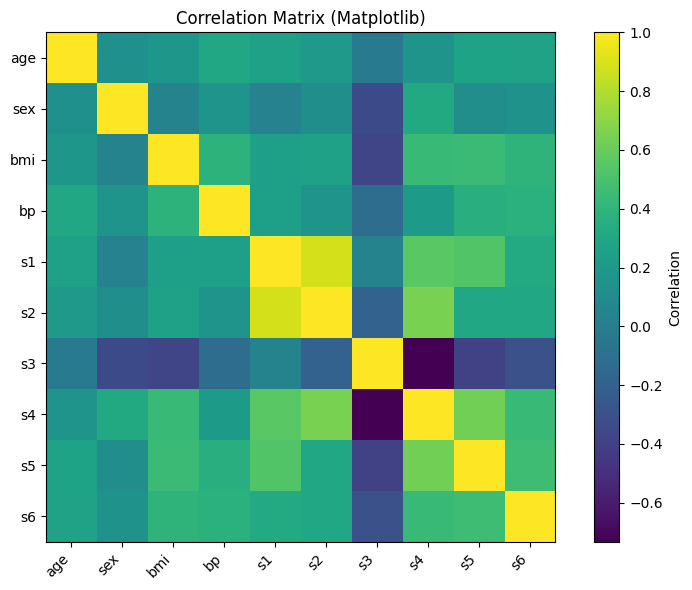

In [65]:
import numpy as np
import matplotlib.pyplot as plt

corr = X_train.corr().values
features = X_train.columns

plt.figure(figsize=(8, 6))
plt.imshow(corr, interpolation='nearest')
plt.colorbar(label='Correlation')
plt.xticks(np.arange(len(features)), features, rotation=45, ha='right')
plt.yticks(np.arange(len(features)), features)

plt.title("Correlation Matrix (Matplotlib)")
plt.tight_layout()
plt.show()

In [69]:
A = X_train.loc[:,['bp', 'bmi', 's5']]
compute_vif(A)

,feature,VIF
0,bp,1.240073
1,bmi,1.349773
2,s5,1.323974


In [4]:
variances = X_train['bp', 'bmi', 's5'].var()

def compute_vif(df: pd.DataFrame):
    vif_data = []
    X_values = df.values

    for i in range(df.shape[1]):
        vif_val = vif(X_values, i)
        vif_data.append(vif_val)

    return pd.DataFrame({
        "feature": df.columns,
        "VIF": vif_data
    })

vif_df = compute_vif(X_train)
merged = pd.concat([
    variances.rename("variance"),
    vif_df.set_index("feature")["VIF"]
], axis=1)

merged

,variance,VIF
age,0.002144,1.202558
sex,0.002272,1.240147
bmi,0.002309,1.554188
bp,0.002304,1.414228
s1,0.002308,53.872720
s2,0.002298,34.744973
s3,0.002251,13.794775
s4,0.002358,9.267345
s5,0.002301,10.118703
s6,0.002305,1.493868


### Implementacja różnych metod selekcji cech

#### a) Variance treshold

In [7]:
var_thresh = VarianceThreshold(threshold=0.001)
var_thresh.fit(X_train)

support_mask = var_thresh.get_support()
selected_features_var = X_train.columns[support_mask]

print("Cechy po VarianceThreshold:")
print(list(selected_features_var))
print("Liczba cech:", len(selected_features_var))

Cechy po VarianceThreshold:
['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
Liczba cech: 10


#### b) Univariate selection – SelectKBest

In [44]:
def show_kbest_scores(selector, feature_names, title):
    scores = selector.scores_
    ranking = pd.DataFrame({
        "feature": feature_names,
        "score": scores
    }).sort_values("score", ascending=False)
    print(f"\n=== {title} ===")
    print(ranking)

# a) f_regression, różne k
for k in [5, 7, 'all']:
    if k == 'all':
        k_val = X_train.shape[1]
    else:
        k_val = k

    skb_f = SelectKBest(score_func=f_regression, k=k_val)
    skb_f.fit(X_train, y_train)
    selected = X_train.columns[skb_f.get_support()]
    print(f"\nSelectKBest(f_regression, k={k_val}) – wybrane cechy:")
    print(list(selected))

# ranking dla f_regression
skb_f_all = SelectKBest(score_func=f_regression, k='all')
skb_f_all.fit(X_train, y_train)
show_kbest_scores(skb_f_all, X_train.columns, "SelectKBest(f_regression) – wszystkie cechy")

skb_mi_all = SelectKBest(score_func=mutual_info_regression, k='all')
skb_mi_all.fit(X_train, y_train)
show_kbest_scores(skb_mi_all, X_train.columns, "SelectKBest(mutual_info_regression) – wszystkie cechy")



SelectKBest(f_regression, k=5) – wybrane cechy:
['bmi', 'bp', 's3', 's4', 's5']

SelectKBest(f_regression, k=7) – wybrane cechy:
['age', 'bmi', 'bp', 's3', 's4', 's5', 's6']

SelectKBest(f_regression, k=10) – wybrane cechy:
['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

=== SelectKBest(f_regression) – wszystkie cechy ===
  feature       score
2     bmi  177.047803
8      s5  115.518898
3      bp   76.555072
7      s4   69.612341
6      s3   59.224887
9      s6   52.803378
0     age   11.596264
4      s1   11.095720
5      s2    7.941295
1     sex    0.003732

=== SelectKBest(mutual_info_regression) – wszystkie cechy ===
  feature     score
2     bmi  0.256936
8      s5  0.172811
7      s4  0.117859
9      s6  0.112602
3      bp  0.092712
5      s2  0.091111
6      s3  0.044983
4      s1  0.032299
1     sex  0.021392
0     age  0.004723


#### c) RFE i RFECV z LinearRegression

In [9]:
base_linreg = LinearRegression()

# RFE dla 3, 5, 7 cech
for n_features in [3, 5, 7]:
    rfe = RFE(estimator=base_linreg, n_features_to_select=n_features)
    rfe.fit(X_train, y_train)
    selected = X_train.columns[rfe.get_support()]
    print(f"\nRFE (n_features={n_features}) – wybrane cechy:")
    print(list(selected))

# RFECV – automatyczny wybór liczby cech
rfecv = RFECV(estimator=base_linreg, cv=5, scoring='r2')
rfecv.fit(X_train, y_train)

print("\nRFECV – optymalna liczba cech:", rfecv.n_features_)
print("Wybrane cechy:")
print(list(X_train.columns[rfecv.get_support()]))



RFE (n_features=3) – wybrane cechy:
['bmi', 's1', 's5']

RFE (n_features=5) – wybrane cechy:
['bmi', 'bp', 's1', 's2', 's5']

RFE (n_features=7) – wybrane cechy:
['sex', 'bmi', 'bp', 's1', 's2', 's4', 's5']

RFECV – optymalna liczba cech: 8
Wybrane cechy:
['sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5']


#### d) Model Based Selection – LassoCV, RandomForest


In [11]:
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train, y_train)

sfm_lasso = SelectFromModel(estimator=lasso, prefit=True)
selected_lasso = X_train.columns[sfm_lasso.get_support()]
print("SelectFromModel(LassoCV) – wybrane cechy:")
print(list(selected_lasso))

rf_temp = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)
rf_temp.fit(X_train, y_train)

importances = rf_temp.feature_importances_
rf_importance_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importances
}).sort_values("importance", ascending=False)

print("\nRandomForest feature importance:")
print(rf_importance_df)

threshold = 0.05
sfm_rf = SelectFromModel(rf_temp, prefit=True, threshold=threshold)
selected_rf = X_train.columns[sfm_rf.get_support()]
print(f"\nSelectFromModel(RandomForest, threshold={threshold}) – wybrane cechy:")
print(list(selected_rf))

SelectFromModel(LassoCV) – wybrane cechy:
['age', 'sex', 'bmi', 'bp', 's1', 's2', 's4', 's5', 's6']

RandomForest feature importance:
  feature  importance
2     bmi    0.383259
8      s5    0.180180
3      bp    0.105970
9      s6    0.067267
0     age    0.060209
6      s3    0.059223
5      s2    0.053092
4      s1    0.050964
7      s4    0.028984
1     sex    0.010852

SelectFromModel(RandomForest, threshold=0.05) – wybrane cechy:
['age', 'bmi', 'bp', 's1', 's2', 's3', 's5', 's6']


#### e) Ensemble/Voting selection

In [16]:
methods_selected = []


methods_selected.append(set(selected_features_var))


skb_f_5 = SelectKBest(score_func=f_regression, k=5)
skb_f_5.fit(X_train, y_train)
methods_selected.append(set(X_train.columns[skb_f_5.get_support()]))


rfe_5 = RFE(estimator=LinearRegression(), n_features_to_select=5)
rfe_5.fit(X_train, y_train)
methods_selected.append(set(X_train.columns[rfe_5.get_support()]))
methods_selected.append(set(selected_lasso))
methods_selected.append(set(selected_rf))


from collections import Counter

all_features = list(X_train.columns)
votes = Counter()
for feat_set in methods_selected:
    for f in feat_set:
        votes[f] += 1

votes_df = pd.DataFrame({
    "feature": all_features,
    "votes": [votes[f] for f in all_features]
}).sort_values("votes", ascending=False)

print("Głosowanie większościowe – liczba głosów na cechę:")
print(votes_df)


ensemble_selected = votes_df.loc[votes_df["votes"] >= 3, "feature"].tolist()
print("\nCechy wybrane przez ensemble (>=3 głosy):")
print(ensemble_selected)

Głosowanie większościowe – liczba głosów na cechę:
  feature  votes
3      bp      5
2     bmi      5
8      s5      5
4      s1      4
5      s2      4
0     age      3
7      s4      3
6      s3      3
9      s6      3
1     sex      2

Cechy wybrane przez ensemble (>=3 głosy):
['bp', 'bmi', 's5', 's1', 's2', 'age', 's4', 's3', 's6']


### Tworzenie Pipeline'ów dla każdej kombinacji

In [18]:
regressors = {
    "kNN": KNeighborsRegressor(),
    "SVR": SVR(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(
        random_state=42,
        objective="reg:squarederror",
        n_estimators=300
    )
}

fs_methods = {
    "none": None,
    "selectkbest5": SelectKBest(score_func=f_regression, k=5),
    "rfe5": RFE(estimator=LinearRegression(), n_features_to_select=5),
    "lasso_sfm": SelectFromModel(LassoCV(cv=5, random_state=42)),
}

def make_pipeline(fs_method, regressor):
    if fs_method is None:
        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("regressor", regressor)
        ])
    else:
        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("feature_selection", fs_method),
            ("regressor", regressor)
        ])
    return pipeline

In [20]:
import time

In [35]:
results = []

n_train = X_train.shape[0]

for reg_name, reg in regressors.items():
    for fs_name, fs in fs_methods.items():
        pipeline = make_pipeline(fs, reg)
        start = time.time()
        pipeline.fit(X_train, y_train)
        end = time.time()
        y_pred = pipeline.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        if fs is None:
            p = X_train.shape[1]
        else:
            if hasattr(pipeline.named_steps["feature_selection"], "get_support"):
                mask = pipeline.named_steps["feature_selection"].get_support()
                p = int(mask.sum())
            else:
                p = X_train.shape[1]

        adj_r2 = 1 - (1 - r2) * (n_train - 1) / (n_train - p - 1)

        results.append({
            "regressor": reg_name,
            "feature_selection": fs_name,
            "MAE": mae,
            "RMSE": rmse,
            "R2": r2,
            "Adj_R2": adj_r2,
            "n_features": p,
            "train_time": end - start
        })

results_df = pd.DataFrame(results).sort_values("MAE")
results_df


,regressor,feature_selection,MAE,RMSE,R2,Adj_R2,n_features,train_time
8,RandomForest,none,42.712406,2859.391091,0.470317,0.452543,10,0.425571
11,RandomForest,lasso_sfm,43.065564,2862.036651,0.469827,0.453869,9,0.235208
2,kNN,rfe5,43.679699,3085.653233,0.428404,0.418971,5,0.010524
9,RandomForest,selectkbest5,43.766917,3016.439388,0.441225,0.432004,5,0.184238
3,kNN,lasso_sfm,44.359398,3358.030977,0.377947,0.359223,9,0.047279
10,RandomForest,rfe5,44.449774,3157.448311,0.415104,0.405452,5,0.176051
0,kNN,none,44.804511,3277.736842,0.392821,0.372446,10,0.004995
1,kNN,selectkbest5,44.863158,3247.059850,0.398504,0.388578,5,0.006009
12,XGBoost,none,46.281674,3513.916100,0.349071,0.327228,10,0.093831
15,XGBoost,lasso_sfm,46.454949,3455.206902,0.359946,0.340680,9,0.144028


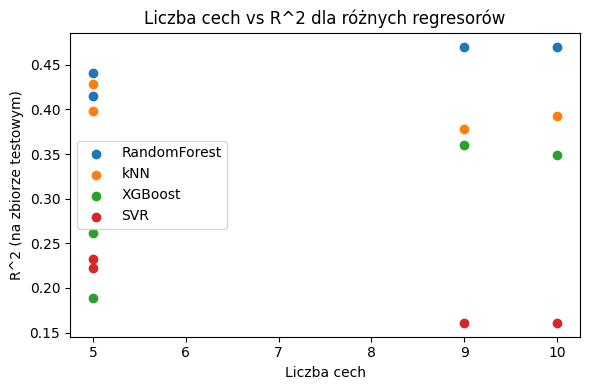

In [46]:
plt.figure(figsize=(6, 4))

for reg_name in results_df["regressor"].unique():
    subset = results_df[results_df["regressor"] == reg_name]
    plt.scatter(subset["n_features"], subset["R2"], label=reg_name)

plt.xlabel("Liczba cech")
plt.ylabel("R^2 (na zbiorze testowym)")
plt.title("Liczba cech vs R^2 dla różnych regresorów")
plt.legend()
plt.tight_layout()
plt.show()


### Optuna optimization

In [47]:
def metric(y_hat, y_true, features_shape):
    n, p = features_shape
    r2 = r2_score(y_true, y_hat)
    scores = {
        "MAE": mean_absolute_error(y_true, y_hat),
        "MSE": mean_squared_error(y_true, y_hat),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_hat)),
        "R2": r2,
        "Adjusted R2": 1 - (1 - r2) * (n - 1) / (n - p - 1)
    }
    df_score = pd.DataFrame(scores.items(), columns=["Metric", "Value"])
    return df_score

In [48]:
def create_fs_from_trial(trial, fs_choice):
    if fs_choice == "none":
        return None
    if fs_choice == "selectkbest":
        k = trial.suggest_int("k", 3, 10)
        score_func_name = trial.suggest_categorical("score_func", ["f_reg", "mi"])
        if score_func_name == "f_reg":
            score_func = f_regression
        else:
            score_func = mutual_info_regression
        return SelectKBest(score_func=score_func, k=k)
    if fs_choice == "rfe":
        n_features = trial.suggest_int("n_features_rfe", 3, X_train.shape[1])
        return RFE(estimator=LinearRegression(), n_features_to_select=n_features)
    if fs_choice == "lasso_sfm":
        return SelectFromModel(LassoCV(cv=5, random_state=42))
    return None


def create_regressor_from_trial(trial, model_name):
    if model_name == "kNN":
        n_neighbors = trial.suggest_int("n_neighbors", 3, 30)
        weights = trial.suggest_categorical("weights", ["uniform", "distance"])
        return KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights)

    if model_name == "SVR":
        C = trial.suggest_loguniform("C", 1e-2, 1e2)
        epsilon = trial.suggest_loguniform("epsilon", 1e-3, 1.0)
        gamma = trial.suggest_categorical("gamma", ["scale", "auto"])
        return SVR(C=C, epsilon=epsilon, gamma=gamma, kernel="rbf")

    if model_name == "RandomForest":
        n_estimators = trial.suggest_int("n_estimators", 100, 500)
        max_depth = trial.suggest_int("max_depth", 3, 20)
        max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
        return RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            max_features=max_features,
            random_state=42,
            n_jobs=-1
        )

    if model_name == "XGBoost":
        n_estimators = trial.suggest_int("n_estimators", 100, 500)
        max_depth = trial.suggest_int("max_depth", 2, 8)
        learning_rate = trial.suggest_loguniform("learning_rate", 1e-2, 0.3)
        subsample = trial.suggest_uniform("subsample", 0.6, 1.0)
        colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.6, 1.0)
        return XGBRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            objective="reg:squarederror",
            random_state=42,
            n_jobs=-1
        )




def objective(trial):
    model_name = trial.suggest_categorical("model_name", ["kNN", "SVR", "RandomForest", "XGBoost"])
    fs_choice = trial.suggest_categorical("fs_choice", ["none", "selectkbest", "rfe", "lasso_sfm"])

    fs = create_fs_from_trial(trial, fs_choice)
    reg = create_regressor_from_trial(trial, model_name)

    if fs is None:
        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("regressor", reg)
        ])
    else:
        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("feature_selection", fs),
            ("regressor", reg)
        ])

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(
        pipeline,
        X_train,
        y_train,
        cv=cv,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1
    )
    rmse_cv = -scores.mean()

    start = time.time()
    pipeline.fit(X_train, y_train)
    end = time.time()

    y_hat = pipeline.predict(X_test)

    if fs is None:
        p_eff = X_train.shape[1]
        feature_names = list(X.columns)
    else:
        step_fs = pipeline.named_steps["feature_selection"]
        if hasattr(step_fs, "get_support"):
            mask = step_fs.get_support()
            feature_names = list(X.columns[mask])
            p_eff = len(feature_names)
        else:
            feature_names = list(X.columns)
            p_eff = X_train.shape[1]

    n_test = len(y_test)
    metrics_df = metric(y_hat, y_test, (n_test, p_eff))

    trial.set_user_attr("model_name", model_name)
    trial.set_user_attr("fs_choice", fs_choice)
    trial.set_user_attr("n_features", p_eff)
    trial.set_user_attr("feature_names", feature_names)
    trial.set_user_attr("metrics_df", metrics_df)
    trial.set_user_attr("train_time", end - start)

    r2_value = metrics_df[metrics_df["Metric"] == "R2"]["Value"].iloc[0]
    trial.set_user_attr("test_R2", r2_value)

    return rmse_cv



In [51]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=150, show_progress_bar=False)

best_trial = study.best_trial
best_trial.params, best_trial.user_attrs

[I 2025-11-18 04:18:22,166] A new study created in memory with name: no-name-1557819a-9eef-4b3a-8e8e-1b4162ead37b
C:\Users\Piotr Matusiewicz\AppData\Local\Temp\ipykernel_8032\1327943708.py:47: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-2, 0.3)
C:\Users\Piotr Matusiewicz\AppData\Local\Temp\ipykernel_8032\1327943708.py:48: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.6, 1.0)
C:\Users\Piotr Matusiewicz\AppData\Local\Temp\ipykernel_8032\1327943708.py:49: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/op

({'model_name': 'kNN',
  'fs_choice': 'none',
  'n_neighbors': 13,
  'weights': 'uniform'},
 {'model_name': 'kNN',
  'fs_choice': 'none',
  'n_features': 10,
  'feature_names': ['age',
   'sex',
   'bmi',
   'bp',
   's1',
   's2',
   's3',
   's4',
   's5',
   's6'],
  'metrics_df':         Metric        Value
  0          MAE    43.978600
  1          MSE  3095.222183
  2         RMSE    55.634721
  3           R2     0.426631
  4  Adjusted R2     0.379634,
  'train_time': 0.002007007598876953,
  'test_R2': np.float64(0.4266310260172539)})

In [52]:
rows = []

for t in study.trials:
    if t.state != optuna.trial.TrialState.COMPLETE:
        continue

    attrs = t.user_attrs
    metrics_df = attrs["metrics_df"]
    metrics_dict = metrics_df.set_index("Metric")["Value"].to_dict()

    row = {
        "trial_number": t.number,
        "model_name": attrs["model_name"],
        "fs_choice": attrs["fs_choice"],
        "n_features": attrs["n_features"],
        "train_time": attrs["train_time"],
    }
    row.update(metrics_dict)
    rows.append(row)

eval_df = pd.DataFrame(rows)
eval_df_sorted = eval_df.sort_values(["RMSE", "model_name"])
eval_df_sorted


,trial_number,model_name,fs_choice,n_features,train_time,MAE,MSE,RMSE,R2,Adjusted R2
35,35,SVR,selectkbest,10,0.007590,40.384161,2699.493274,51.956648,0.499937,0.458948
127,127,SVR,none,10,0.006759,40.517313,2710.031891,52.057967,0.497985,0.456836
59,59,RandomForest,none,10,0.233052,41.916405,2720.687059,52.160206,0.496011,0.454701
6,6,RandomForest,none,10,0.290084,42.038789,2721.498150,52.167980,0.495861,0.454538
67,67,RandomForest,none,10,0.217977,41.808171,2721.802930,52.170901,0.495804,0.454477
...,...,...,...,...,...,...,...,...,...,...
4,4,SVR,lasso_sfm,9,0.039013,57.813066,4671.170138,68.345959,0.134697,0.071382
7,7,SVR,selectkbest,7,0.020010,61.417921,5193.030103,72.062682,0.038026,-0.015844
145,145,SVR,none,10,0.005122,62.426142,5339.380427,73.071064,0.010916,-0.070157
1,1,SVR,none,10,0.007005,62.764335,5391.236365,73.425039,0.001310,-0.080550


In [57]:
best_params = best_trial.params
best_model_name = best_trial.user_attrs["model_name"]
best_fs_choice = best_trial.user_attrs["fs_choice"]

best_fs = create_fs_from_trial(best_trial, best_fs_choice)
best_reg = create_regressor_from_trial(best_trial, best_model_name)

if best_fs is None:
    best_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", best_reg)
    ])
else:
    best_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("feature_selection", best_fs),
        ("regressor", best_reg)
    ])

best_pipeline.fit(X_train, y_train)
y_hat_best = best_pipeline.predict(X_test)

if best_fs is None:
    feature_names_best = list(X.columns)
else:
    step_fs = best_pipeline.named_steps["feature_selection"]
    if hasattr(step_fs, "get_support"):
        mask_best = step_fs.get_support()
        feature_names_best = list(X.columns[mask_best])
    else:
        feature_names_best = list(X.columns)

if hasattr(best_pipeline.named_steps["regressor"], "feature_importances_"):
    importances_best = best_pipeline.named_steps["regressor"].feature_importances_
    fi_best = pd.Series(importances_best, index=feature_names_best).sort_values(ascending=False)
else:
    fi_best = None

print(fi_best)

None


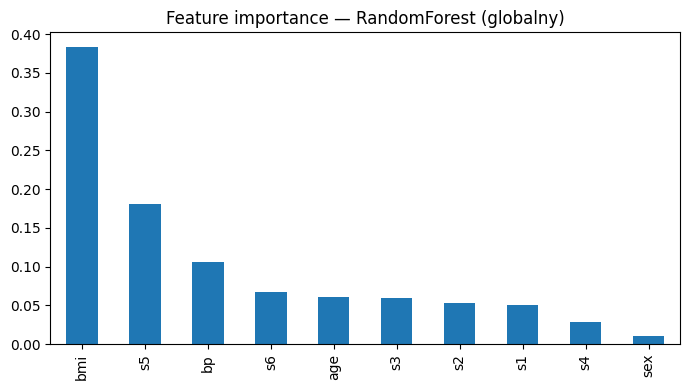

In [59]:
rf_global = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)
rf_global.fit(X_train, y_train)
rf_global_importances = pd.Series(rf_global.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(7, 4))
rf_global_importances.plot(kind="bar")
plt.title("Feature importance — RandomForest (globalny)")
plt.tight_layout()
plt.show()

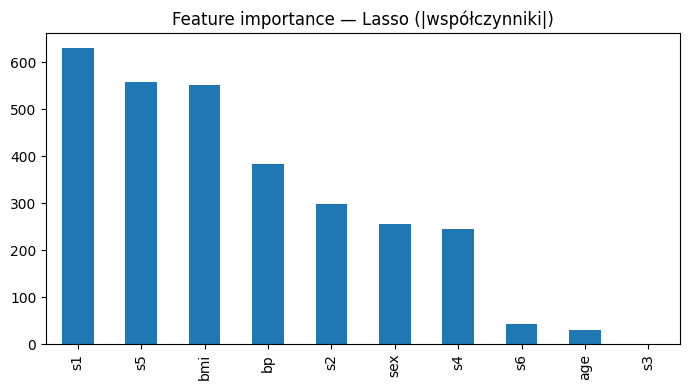

In [60]:
lasso_global = LassoCV(cv=5, random_state=42)
lasso_global.fit(X_train, y_train)
lasso_coefs_global = pd.Series(lasso_global.coef_, index=X.columns).abs().sort_values(ascending=False)

plt.figure(figsize=(7, 4))
lasso_coefs_global.plot(kind="bar")
plt.title("Feature importance — Lasso (|współczynniki|)")
plt.tight_layout()
plt.show()


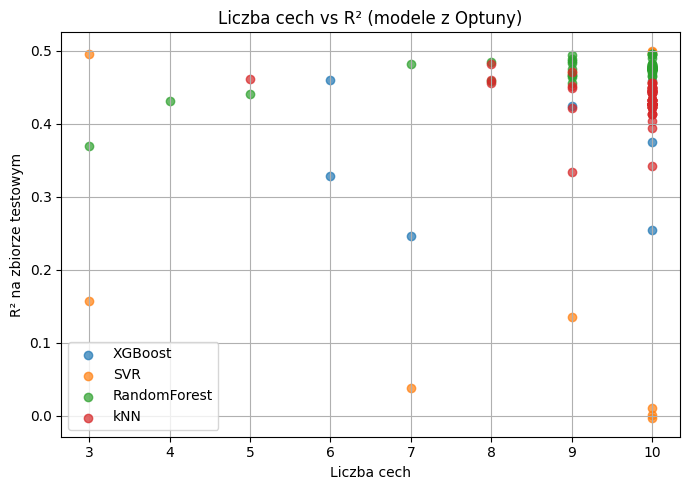

In [61]:
plt.figure(figsize=(7, 5))
for name in eval_df["model_name"].unique():
    subset = eval_df[eval_df["model_name"] == name]
    plt.scatter(subset["n_features"], subset["R2"], label=name, alpha=0.7)

plt.xlabel("Liczba cech")
plt.ylabel("R² na zbiorze testowym")
plt.title("Liczba cech vs R² (modele z Optuny)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
